In [1]:
!nvidia-smi

Sat May 15 09:19:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   38C    P0    29W / 250W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
import os, time
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor) # 앞의 2개 --> mmdet/datasets/builder.py에 존재 / 마지막 1개 --> 
from mmdet.models import build_detector #mmdet/models/builder.py에 존재
from mmdet.apis import (train_detector, single_gpu_test, init_detector, inference_detector, show_result_pyplot) 
    # train_detector --> mmdet/apis/train.py에 존재, init_detector, inference_detector, show_result_pyplot --> mmdet/apis/inference.py에 존재, single_gpu_test -->  mmdet/apis/test.py에 존재
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np
import json

ImportError: cannot import name 'deform_conv_cuda' from 'mmdet.ops.dcn' (/opt/ml/code/mmdetection_trash/mmdet/ops/dcn/__init__.py)

## train part

In [3]:
#temp
'''
config_dir_name = 'detectors'
config_file_name = 'detectors_htc_r50_2x_coco'
cfg = Config.fromfile('../configs/'+config_dir_name+'/'+config_file_name+'.py')
working_dir_name = '../work_dirs/' + config_file_name +'_'+str(cfg.runner.max_epochs)

try:
    if not os.path.exists(working_dir_name):
        os.makedirs(working_dir_name)
except OSError :
    print('Error: Creating directory :: ' + working_dir_name)
cfg_str = str(cfg)[str(cfg).find(')')+3:]
cfg_dict = eval(cfg_str); 
with open(working_dir_name+'/config.json','w') as config_json_file :
    json.dump(cfg_dict, config_json_file, indent="\t")
#config 저장 확인
with open(working_dir_name+'/config.json', 'r') as f :
    json_data = json.load(f)
json_data
'''



'\nconfig_dir_name = \'detectors\'\nconfig_file_name = \'detectors_htc_r50_2x_coco\'\ncfg = Config.fromfile(\'../configs/\'+config_dir_name+\'/\'+config_file_name+\'.py\')\nworking_dir_name = \'../work_dirs/\' + config_file_name +\'_\'+str(cfg.runner.max_epochs)\n\ntry:\n    if not os.path.exists(working_dir_name):\n        os.makedirs(working_dir_name)\nexcept OSError :\n    print(\'Error: Creating directory :: \' + working_dir_name)\ncfg_str = str(cfg)[str(cfg).find(\')\')+3:]\ncfg_dict = eval(cfg_str); \nwith open(working_dir_name+\'/config.json\',\'w\') as config_json_file :\n    json.dump(cfg_dict, config_json_file, indent="\t")\n#config 저장 확인\nwith open(working_dir_name+\'/config.json\', \'r\') as f :\n    json_data = json.load(f)\njson_data\n'

In [2]:
classes = ("UNKNOWN", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")
# config file 들고오기
#cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')
#파일 교체 시 여기 이름 바꾸기
config_dir_name = 'detectors'
config_file_name = 'DetectoRS_mstrain_400_1200_r50'
cfg = Config.fromfile('../configs/'+config_dir_name+'/'+config_file_name+'.py')

PREFIX = '/opt/ml/input/data/'

#data 경로 설정
cfg.data_root = PREFIX

# dataset 바꾸기
cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = PREFIX + 'train.json'
cfg.data.train.pipeline[2]['img_scale'] = (512, 512)

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = PREFIX + 'val.json'
cfg.data.val.pipeline[1]['img_scale'] = (512, 512)

cfg.data.test.classes = classes
cfg.data.test.img_prefix = PREFIX
cfg.data.test.ann_file = PREFIX + 'test.json'
cfg.data.test.pipeline[1]['img_scale'] = (512, 512)

cfg.data.samples_per_gpu = 16    #batch size
cfg.data.workers_per_gpu = 4     #worker num

cfg.seed=42 #42로 고정
cfg.gpu_ids = [0]

#epoch 수 조정
cfg.runner.max_epochs = 24

#class 개수 설정
cfg.model.bbox_head[0].num_classes = 11 
cfg.model.bbox_head[1].num_classes = 11
cfg.model.bbox_head[2].num_classes = 11

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)

#working directory 이름 설정
working_dir_name = '../work_dirs/' + config_file_name +'_'+str(cfg.runner.max_epochs)
cfg.work_dir = working_dir_name


## wandb setting

In [3]:
group_name = 'detectors'; project_name = 'gjtak'; run_name = config_file_name
config_list = {
    'epoch' : cfg.runner.max_epochs,
    'batch_size' :  cfg.data.samples_per_gpu,
    'optimizer' : cfg.optimizer,
    'optimizer_config' : cfg.optimizer_config,
    'lr_config' : cfg.lr_config,
}
cfg.log_config.hooks[1].init_kwargs['group']=group_name # group name(option)
cfg.log_config.hooks[1].init_kwargs['name'] = run_name # run name
cfg.log_config.hooks[1].init_kwargs['config'] = config_list # config

### config 저장

In [4]:
# config 객체 -> 파일(json)로 저장(저장 장소 = working directory와 같이)
#working directory 없으면 생성하기
try:
    if not os.path.exists(working_dir_name):
        os.makedirs(working_dir_name)
except OSError :
    print('Error: Creating directory :: ' + working_dir_name)

#cfg 객체 -> string(str이용) -> dict(eval이용) -> json 으로 저장
cfg_str = str(cfg)[str(cfg).find(')')+3:]
cfg_dict = eval(cfg_str)
with open(working_dir_name+'/config.json','w') as config_json_file :
    json.dump(cfg_dict, config_json_file, indent="\t")


In [5]:
#config 저장 확인
with open(working_dir_name+'/config.json', 'r') as f :
    json_data = json.load(f)
#json_data

In [7]:
model = build_detector(cfg.model)

KeyError: 'RecursiveFeaturePyramid is not in the detector registry'

In [8]:
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=3.76s)
creating index...
index created!


In [9]:
start = time.time()  # 시작 시간 저장
train_detector(model, datasets[0], cfg, distributed=False, validate=True)
print("time(sec) :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간(단위 : 초)

loading annotations into memory...
2021-05-13 17:46:06,910 - mmdet - INFO - Start running, host: root@7abc6b7bc976, work_dir: /opt/ml/p3-ims-obd-hansarang/gjtak_works/Object Detection/code/mmdetection_trash/work_dirs/detectors_htc_r50_2x_coco_24
2021-05-13 17:46:06,911 - mmdet - INFO - workflow: [('train', 1)], max: 24 epochs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Done (t=0.88s)
creating index...
index created!
wandb: Currently logged in as: pstage3_det (use `wandb login --relogin` to force relogin)


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/ml/code/mmdetection_trash/mmdet/datasets/custom.py", line 193, in __getitem__
    data = self.prepare_train_img(idx)
  File "/opt/ml/code/mmdetection_trash/mmdet/datasets/custom.py", line 216, in prepare_train_img
    return self.pipeline(results)
  File "/opt/ml/code/mmdetection_trash/mmdet/datasets/pipelines/compose.py", line 40, in __call__
    data = t(data)
  File "/opt/ml/code/mmdetection_trash/mmdet/datasets/pipelines/loading.py", line 373, in __call__
    results = self._load_semantic_seg(results)
  File "/opt/ml/code/mmdetection_trash/mmdet/datasets/pipelines/loading.py", line 346, in _load_semantic_seg
    results['ann_info']['seg_map'])
  File "/opt/conda/lib/python3.7/posixpath.py", line 80, in join
    a = os.fspath(a)
TypeError: expected str, bytes or os.PathLike object, not NoneType


# Inference part

In [7]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'epoch_{epoch}.pth')

## \[option\] box inference image result

In [22]:
model_for_img_test = init_detector(cfg, checkpoint_path, device='cuda:0')

Use load_from_local loader
/opt/ml/code/mmdetection_trash/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


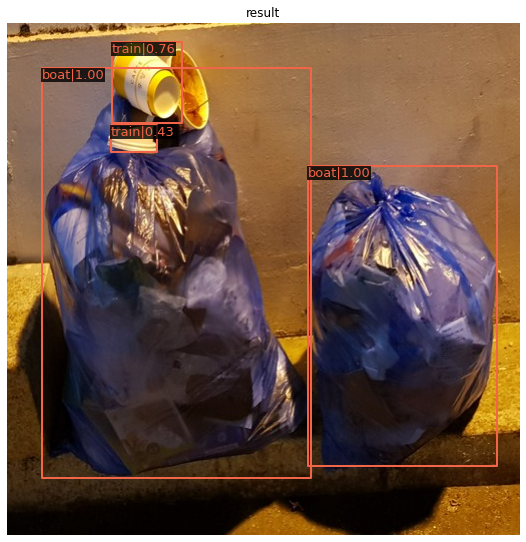

In [31]:
img_dir_num = ['01', '02', '03'] 
img_num = '0003'
img = '/opt/ml/input/data/batch_'+img_dir_num[1]+'_vt/'+img_num+'.jpg'
result = inference_detector(model_for_img_test, img)
# show the results
show_result_pyplot(model_for_img_test, img, result)

# Real Inference

In [ ]:
epoch = cfg.runner.max_epochs
cfg.model.train_cfg = None

In [14]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [15]:
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

2021-05-13 13:30:57,836 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w40
2021-05-13 13:30:57,837 - mmdet - INFO - Use load_from_openmmlab loader
2021-05-13 13:30:58,354 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0

In [16]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 837/837, 12.0 task/s, elapsed: 70s, ETA:     0s

In [17]:
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
imag_ids = coco.getImgIds()

class_num = 11
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names

submission.to_csv(os.path.join(cfg.work_dir, 'submission_'+config_file_name+f'_{epoch}.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


,PredictionString,image_id
0,1 0.2939718 130.92 47.97619 256.9035 162.15506...,batch_01_vt/0021.jpg
1,8 0.9985936 7.4602966 242.27399 299.74802 458....,batch_01_vt/0028.jpg
2,0 0.075662985 330.71027 0.0 428.31854 0.0 0 0....,batch_01_vt/0031.jpg
3,1 0.062311463 290.7938 157.91553 360.8652 226....,batch_01_vt/0032.jpg
4,1 0.96555096 389.13928 271.5741 473.43427 343....,batch_01_vt/0070.jpg
